In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [14]:
import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import albumentations as A
import pickle as pkl
from UNET_model import UNET
from dataset import PetDataset, convert_color_to_class, remove_class_dimension
from autoencoder import Autoencoder



random.seed(42)

In [3]:
# constants
TRAIN_IMAGE_DIR = "/teamspace/studios/this_studio/CV-2/Dataset/TrainVal/color"
TRAIN_MASK_DIR = "/teamspace/studios/this_studio/CV-2/Dataset/TrainVal/label"
TEST_IMAGE_DIR = "/teamspace/studios/this_studio/CV-2/Dataset/Test/color"
TEST_MASK_DIR = "/teamspace/studios/this_studio/CV-2/Dataset/Test/label"

In [4]:
def check_mask_uniqueness(img_path, mode, animal):
    image = Image.open(img_path).convert(mode)
    image_arr = np.array(image)
    print(f"type: {animal} mode: {mode} unique: {np.unique(image_arr)}")

check_mask_uniqueness(os.path.join(TRAIN_MASK_DIR, "Abyssinian_1.png"), "L", "cat")
check_mask_uniqueness(os.path.join(TRAIN_MASK_DIR, "american_bulldog_130.png"), "L", "dog")

type: cat mode: L unique: [  0  38 255]
type: dog mode: L unique: [  0  75 255]


In [5]:
# investigating the unique values in the segmentation mask for both training and test
def get_valid_masks(dataset_dir):
    classes = set()
    masks = os.listdir(dataset_dir)
    valid_masks = masks.copy()
    missing_masks = []

    for mask in masks:
        mask_img = read_image(os.path.join(dataset_dir, mask))
        unique_mask_values = mask_img.unique()

        # corrupted / missing mask
        if (len(unique_mask_values)) != 3:
            print(f"Missing mask: {mask}")
            missing_masks.append(mask)
            valid_masks.remove(mask)
            continue

        background = unique_mask_values[0].item()
        subject = unique_mask_values[1].item()
        boundary = unique_mask_values[2].item()

        classes.add(background)
        classes.add(subject)
        classes.add(boundary)

    print(f"Classes: {classes}")
    return valid_masks
    
train_valid_masks = get_valid_masks(TRAIN_MASK_DIR)
test_valid_masks = get_valid_masks(TEST_MASK_DIR)

Classes: {0, 1, 2, 255}
Classes: {0, 1, 2, 255}


In [6]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),
    # A.ColorJitter(), 
    A.Normalize(), # does not affect mask
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)

test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(),  # 与训练集一致
    A.ToTensorV2(transpose_mask=True),
])
 

In [7]:
train_val_dataset = PetDataset(image_dir=TRAIN_IMAGE_DIR, mask_dir=TRAIN_MASK_DIR, valid_masks=train_valid_masks, transform=transform)
test_dataset = PetDataset(image_dir=TEST_IMAGE_DIR, mask_dir=TEST_MASK_DIR, valid_masks=test_valid_masks, transform=test_transform)

In [8]:
train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [10]:
train_image, train_mask = next(iter(train_dataloader))
print(f"Image batch shape: {train_image.size()}")
print(f"Mask batch shape: {train_mask.size()}")
# print(f"Mask unique values: {torch.unique(train_mask, dim=1)}")

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


torch.Size([16, 256, 256])


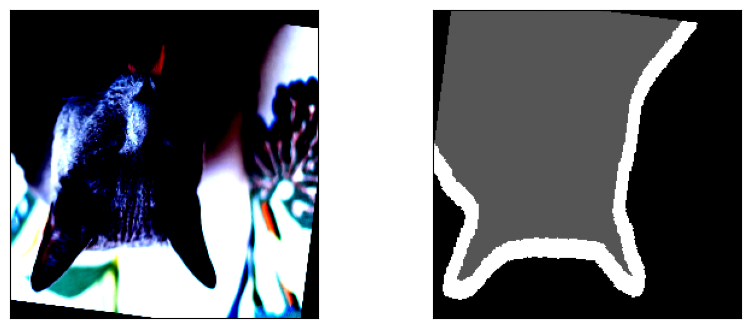

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
fig = plt.imshow(train_image[0].permute(1,2,0)) # squeeze cannot be used here since it only works if bs = 1
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.subplot(1,2,2)
print(f"{train_mask.size()}")
# convert mask back to single seg map
# mask = remove_class_dimension(train_mask[0])
mask = train_mask[0]
fig = plt.imshow(mask, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [12]:
# save the dataset into a pickle file to be loaded in
with open("Dataset/train.pkl", "wb") as f:
    pkl.dump(train_dataset, f)

with open("Dataset/val.pkl", "wb") as f:
    pkl.dump(val_dataset, f)

with open("Dataset/test.pkl", "wb") as f:
    pkl.dump(test_dataset, f)

In [13]:
with open("Dataset/train.pkl", "rb") as f:
    train_dataset = pkl.load(f)

with open("Dataset/val.pkl", "rb") as f:
    val_dataset = pkl.load(f)

with open("Dataset/test.pkl", "rb") as f:
    test_dataset = pkl.load(f)

In [15]:
DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(loader, model, optimizer, loss_fn, scaler):
    model.train()
    loop = tqdm(loader)

    for batch_idx, (images, _) in enumerate(loop):
        images = images.to(device=DEVICE)

        # forward
        with torch.amp.autocast(device_type="cpu"):  # 采用混合精度训练
            predictions = model(images)  # 对图像进行重建
            loss = loss_fn(predictions, images)  # 计算损失（通常使用MSE）

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()  # 使用混合精度反向传播
        scaler.step(optimizer)
        scaler.update()

        # 更新进度条
        loop.set_postfix(loss=loss.item())


In [16]:
# 初始化模型
model = Autoencoder().to(DEVICE)

# 使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 定义损失函数（均方误差损失）
loss_fn = nn.MSELoss()

# 定义混合精度缩放器（用于加速训练）
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_12146/706646730.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [17]:
# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(train_dataloader, model, optimizer, loss_fn, scaler)


Epoch [1/10]


100%|██████████| 184/184 [01:57<00:00,  1.56it/s, loss=1]    


Epoch [2/10]


100%|██████████| 184/184 [01:51<00:00,  1.65it/s, loss=1.05] 


Epoch [3/10]


100%|██████████| 184/184 [01:52<00:00,  1.64it/s, loss=0.931]


Epoch [4/10]


100%|██████████| 184/184 [01:56<00:00,  1.58it/s, loss=1.04] 


Epoch [5/10]


100%|██████████| 184/184 [01:56<00:00,  1.58it/s, loss=0.983]


Epoch [6/10]


100%|██████████| 184/184 [01:51<00:00,  1.65it/s, loss=1.09] 


Epoch [7/10]


100%|██████████| 184/184 [01:56<00:00,  1.58it/s, loss=1.03] 


Epoch [8/10]


100%|██████████| 184/184 [01:56<00:00,  1.58it/s, loss=0.889]


Epoch [9/10]


100%|██████████| 184/184 [01:56<00:00,  1.58it/s, loss=0.89] 


Epoch [10/10]


100%|██████████| 184/184 [02:10<00:00,  1.42it/s, loss=0.963]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151553..2.2146587].


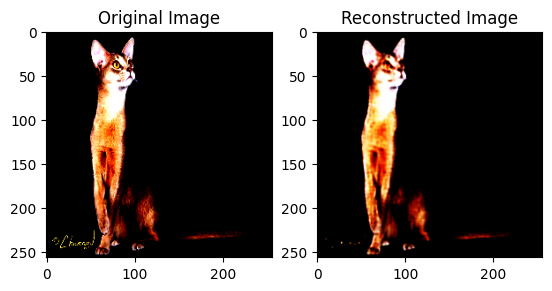

In [18]:
# 可视化重建效果
def visualize_reconstruction(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        images = images.to(device)

        # 获取原图与重建图像
        reconstructed = model(images)

        # 显示结果
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[0].permute(1, 2, 0).cpu())
        ax[0].set_title("Original Image")
        ax[1].imshow(reconstructed[0].permute(1, 2, 0).cpu())
        ax[1].set_title("Reconstructed Image")
        plt.show()

# 在训练后展示
visualize_reconstruction(model, test_dataloader, DEVICE)


In [49]:
def train_segmentation_head(loader, model, optimizer, loss_fn):
    model.train()  # 设置模型为训练模式
    loop = tqdm(loader, total=len(loader), ncols=100)

    device = "cuda" if torch.cuda.is_available() else "cpu"  # 自动选择设备
    for batch_idx, (images, masks) in enumerate(loop):
        images = images.to(device)
        masks = masks.to(device)

        # 将目标mask转换为Long类型
        masks = masks.long()  # CrossEntropyLoss需要标签是Long类型

        # forward
        decoded, segmentation_output = model(images)  # 获取解码器的输出和分割头的输出
        loss = loss_fn(segmentation_output, masks)  # 使用分割头的输出和真实mask计算损失

        # backward
        optimizer.zero_grad()
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新模型参数

        # 更新进度条
        loop.set_postfix(loss=loss.item())  # 在进度条上显示损失值



In [50]:
# 保存编码器权重
encoder_weights = autoencoder.encoder.state_dict()
torch.save(encoder_weights, "encoder_weights.pth")


In [51]:
class AutoencoderWithSegmentationHead(nn.Module):
    def __init__(self, autoencoder, num_classes=4):
        super(AutoencoderWithSegmentationHead, self).__init__()
        self.encoder = autoencoder.encoder  # 提取编码器部分
        self.decoder = autoencoder.decoder  # 提取解码器部分
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),  # 根据编码器的输出调整
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),  # 生成分割预测
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)  # 上采样调整为256x256
        )

    def forward(self, x):
        # 编码器
        encoded = self.encoder(x)
        # 解码器
        decoded = self.decoder(encoded)
        # 分割头
        segmentation_output = self.segmentation_head(encoded)
        return decoded, segmentation_output



In [52]:
encoder = Autoencoder().encoder
encoder.load_state_dict(torch.load("encoder_weights.pth"))  # 加载训练好的编码器权重
for param in encoder.parameters():
    param.requires_grad = False

In [53]:
model = AutoencoderWithSegmentationHead(encoder, num_classes=4)

AttributeError: 'Sequential' object has no attribute 'encoder'

In [60]:
def train_segmentation_head(loader, model, optimizer, loss_fn):
    model.train()  # 设置模型为训练模式
    loop = tqdm(loader, total=len(loader), ncols=100)

    device = "cuda" if torch.cuda.is_available() else "cpu"  # 自动选择设备
    for batch_idx, (images, masks) in enumerate(loop):
        images = images.to(device)
        masks = masks.to(device)

        # 将masks转换为long类型
        masks = masks.long()  # CrossEntropyLoss需要标签是Long类型

        # forward
        decoded, segmentation_output = model(images)  # 获取解码器的输出和分割头的输出
        loss = loss_fn(segmentation_output, masks)  # 使用分割头的输出和真实mask计算损失

        # backward
        optimizer.zero_grad()
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新模型参数

        # 更新进度条
        loop.set_postfix(loss=loss.item())  # 在进度条上显示损失值



In [61]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [62]:
class AutoencoderWithSegmentationHead(nn.Module):
    def __init__(self, encoder, decoder, num_classes=4):
        super(AutoencoderWithSegmentationHead, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),  # 根据编码器的输出调整
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),  # 生成分割预测
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)  # 上采样调整为256x256
        )

    def forward(self, x):
        # 编码器部分
        encoded = self.encoder(x)
        # 解码器部分
        decoded = self.decoder(encoded)
        # 分割头
        segmentation_output = self.segmentation_head(encoded)
        return decoded, segmentation_output

In [63]:
autoencoder = Autoencoder()
encoder_weights = torch.load("encoder_weights.pth")
autoencoder.encoder.load_state_dict(encoder_weights)

# 创建带分割头的模型
model = AutoencoderWithSegmentationHead(autoencoder.encoder, autoencoder.decoder, num_classes=4)

# 优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-4)
segmentation_loss_fn = nn.CrossEntropyLoss()  # 分割任务的损失函数

# 训练分割头
for epoch in range(num_epochs):
    train_segmentation_head(train_loader, model, optimizer, segmentation_loss_fn)

  0%|                                                                       | 0/230 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 230/230 [03:36<00:00,  1.06it/s, loss=0.768]


In [59]:
# 打印masks的类型和形状
print(train_mask.dtype)  # 输出masks的类型
print(train_mask.shape)  # 输出masks的形状


torch.float32
torch.Size([16, 256, 256])


In [72]:
def compute_iou(preds, targets, num_classes):
    # 确保标签和预测都是整数类型
    preds = preds.argmax(dim=1)  # 获取每个像素的预测类别
    iou_total = torch.zeros(num_classes).to(preds.device)
    target_total = torch.zeros(num_classes).to(preds.device)
    pred_total = torch.zeros(num_classes).to(preds.device)
    
    for c in range(num_classes):
        # 计算每个类别的TP, FP, FN
        target_c = (targets == c).float()  # 真实标签中该类别的位置
        pred_c = (preds == c).float()  # 预测标签中该类别的位置
        
        intersection = (target_c * pred_c).sum()  # TP
        union = target_c.sum() + pred_c.sum() - intersection  # FP + FN + TP
        
        iou = intersection / (union + 1e-6)  # IoU = TP / (TP + FP + FN)
        iou_total[c] += iou
        target_total[c] += target_c.sum()
        pred_total[c] += pred_c.sum()
    
    return iou_total

def compute_dice(preds, targets, num_classes):
    # 确保标签和预测都是整数类型
    preds = preds.argmax(dim=1)  # 获取每个像素的预测类别
    dice_total = torch.zeros(num_classes).to(preds.device)
    
    for c in range(num_classes):
        target_c = (targets == c).float()  # 真实标签中该类别的位置
        pred_c = (preds == c).float()  # 预测标签中该类别的位置
        
        intersection = (target_c * pred_c).sum()  # TP
        union = target_c.sum() + pred_c.sum()  # FP + FN + TP
        
        dice = 2 * intersection / (union + intersection + 1e-6)  # Dice = 2 * TP / (TP + FP + FN)
        dice_total[c] += dice
    
    return dice_total



In [73]:

def evaluate_metrics(loader, model, num_classes=4):
    model.eval()
    loop = tqdm(loader, total=len(loader), ncols=100)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    iou_total = [0] * num_classes  # 用于累加每个类别的IoU
    dice_total = [0] * num_classes  # 用于累加每个类别的Dice系数
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device)
            masks = masks.to(device)

            # forward
            _, segmentation_output = model(images)
            
            # 计算IoU
            iou = compute_iou(segmentation_output, masks, num_classes)
            for i in range(num_classes):
                iou_total[i] += iou[i]
            
            # 计算Dice系数
            dice = compute_dice(segmentation_output, masks, num_classes)
            for i in range(num_classes):
                dice_total[i] += dice[i]

    avg_iou = [iou / len(loader) for iou in iou_total]
    avg_dice = [dice / len(loader) for dice in dice_total]

    print(f"Average IoU: {avg_iou}")
    print(f"Average Dice: {avg_dice}")
    
    return avg_iou, avg_dice


In [74]:
# 调用评估函数
avg_iou, avg_dice = evaluate_metrics(test_dataloader, model, num_classes=4)


100%|█████████████████████████████████████████████████████████████| 231/231 [03:30<00:00,  1.10it/s]

Average IoU: [tensor(0.6743), tensor(0.), tensor(0.2778), tensor(0.1549)]
Average Dice: [tensor(0.5727), tensor(0.), tensor(0.3009), tensor(0.2346)]


In [15]:
#crop,dice
import torch
import torch.nn as nn
import torch.optim as optim
import utils  # 假设 utils 里有相关数据加载和检查函数

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets):
        """
        preds: (B, C, H, W) - 经过 softmax 后的预测概率
        targets: (B, H, W) - 每个像素的真实类别索引
        """
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)  # (B, C, H, W)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2)  # (B, C, H, W)

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))  # 按通道求和
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice_score = (2 * intersection + self.eps) / (union + self.eps)
        dice_loss = 1 - dice_score.mean()  # 取均值计算最终 loss
        return dice_loss

model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint_cd.pth.tar"), model)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # 保存模型
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_cd.pth.tar")

    # 计算验证集的准确率
    utils.check_accuracy(val_loader, model, device=DEVICE)

    # 保存预测结果
    # utils.save_predictions_as_imgs(val_loader, model, folder="saved_images", device=DEVICE)

    # )

/tmp/ipykernel_2111/3470919457.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.737]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.695]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.619]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.637]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.614]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.559]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.594]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.549]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.599]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.537]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.625]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.517]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.509]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.551]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.486]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.488]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.502]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.565]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.481]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.533]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.473]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.458]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.493]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.477]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.485]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.439]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.45] 


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.14it/s, loss=0.533]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.431]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.474]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.44] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.449]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.44] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.465]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.487]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.438]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.452]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.436]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.453]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.428]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.473]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.447]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.426]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.403]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.14it/s, loss=0.42] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.426]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.477]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.436]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.429]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.453]


=> Saving checkpoint


In [32]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint_cd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

checkpoint_dict = torch.load("UNET_checkpoint_cd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

checkpoint = torch.load("UNET_checkpoint_cd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

dict_keys(['state_dict', 'optimizer'])


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [22]:
checkpoint_dict = torch.load("UNET_checkpoint_cd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

dict_keys(['state_dict', 'optimizer'])


In [23]:
checkpoint = torch.load("UNET_checkpoint_cd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
#crop,dice,original dataset
def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

total_iou_1, total_dice_1 = 0.0, 0.0
total_iou_2, total_dice_2 = 0.0, 0.0
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)  # targets应为(B, H, W)，每个像素值为类别0,1,2,3
        outputs = model(inputs)  # 假设输出为(B, num_classes, H, W)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)
        for pred, target in zip(preds, targets):
            iou1, dice1 = compute_metrics(pred, target, class_idx=1)
            iou2, dice2 = compute_metrics(pred, target, class_idx=2)
            total_iou_1 += iou1
            total_dice_1 += dice1
            total_iou_2 += iou2
            total_dice_2 += dice2
            num_samples += 1

avg_iou_1 = total_iou_1 / num_samples
avg_dice_1 = total_dice_1 / num_samples
avg_iou_2 = total_iou_2 / num_samples
avg_dice_2 = total_dice_2 / num_samples

print("类别1: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(avg_iou_1, avg_dice_1))
print("类别2: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(avg_iou_2, avg_dice_2))

类别1: 平均 IoU = 0.1537, 平均 Dice = 0.1888
类别2: 平均 IoU = 0.4693, 平均 Dice = 0.5437


In [25]:
import torch

def compute_metrics(pred, target, class_idx, eps=1e-6):
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

# 初始化存储 IoU 和 Dice 系数的字典
num_classes = 4
metrics = {class_idx: {"total_iou": 0.0, "total_dice": 0.0} for class_idx in range(num_classes)}
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)  # targets 形状 (B, H, W)，类别索引 {0,1,2,3}
        outputs = model(inputs)  # 形状 (B, num_classes, H, W)
        preds = torch.argmax(outputs, dim=1)  # 形状 (B, H, W)
        
        for pred, target in zip(preds, targets):
            for class_idx in range(num_classes):
                iou, dice = compute_metrics(pred, target, class_idx)
                metrics[class_idx]["total_iou"] += iou
                metrics[class_idx]["total_dice"] += dice
            num_samples += 1

# 计算平均 IoU 和 Dice
for class_idx in range(num_classes):
    avg_iou = metrics[class_idx]["total_iou"] / num_samples
    avg_dice = metrics[class_idx]["total_dice"] / num_samples
    print("类别 {}: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(class_idx, avg_iou, avg_dice))


类别 0: 平均 IoU = 0.8383, 平均 Dice = 0.9050
类别 1: 平均 IoU = 0.1537, 平均 Dice = 0.1888
类别 2: 平均 IoU = 0.4693, 平均 Dice = 0.5437
类别 3: 平均 IoU = 0.4203, 平均 Dice = 0.5800


In [26]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint2.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

checkpoint_dict = torch.load("UNET_checkpoint2.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

checkpoint = torch.load("UNET_checkpoint2.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

dict_keys(['state_dict', 'optimizer'])


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:

import torch

def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

# 存储各类别的 IoU 和 Dice
class_indices = [0, 1, 2, 3]  # 需要评估的类别
total_metrics = {idx: {"iou": 0.0, "dice": 0.0} for idx in class_indices}
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)  # targets应为(B, H, W)，每个像素值为类别0,1,2,3,4
        outputs = model(inputs)  # 假设输出为(B, num_classes, H, W)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)

        for pred, target in zip(preds, targets):
            for class_idx in class_indices:
                iou, dice = compute_metrics(pred, target, class_idx)
                total_metrics[class_idx]["iou"] += iou
                total_metrics[class_idx]["dice"] += dice
            num_samples += 1

# 计算每个类别的平均 IoU 和 Dice
for class_idx in class_indices:
    avg_iou = total_metrics[class_idx]["iou"] / num_samples
    avg_dice = total_metrics[class_idx]["dice"] / num_samples
    print("类别 {}: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(class_idx, avg_iou, avg_dice))

类别 0: 平均 IoU = 0.7445, 平均 Dice = 0.8376
类别 1: 平均 IoU = 0.1003, 平均 Dice = 0.1318
类别 2: 平均 IoU = 0.4338, 平均 Dice = 0.5138
类别 3: 平均 IoU = 0.4229, 平均 Dice = 0.5814


In [15]:
#crop, 训练dice结合cross entropy的UNet
import torch
import torch.nn as nn
import torch.optim as optim
import utils  # 假设 utils 里有数据加载和检查函数

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)  # (B, C, H, W)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2)  # (B, C, H, W)

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice_score = (2 * intersection + self.eps) / (union + self.eps)
        dice_loss = 1 - dice_score.mean()
        return dice_loss

class AdaptiveLoss(nn.Module):
    def __init__(self, init_alpha=0.5):
        super(AdaptiveLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(init_alpha))  # 让 α 可学习
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, preds, targets):
        alpha = torch.sigmoid(self.alpha)  # 保证 α 在 (0,1) 之间
        return alpha * self.ce_loss(preds, targets) + (1 - alpha) * self.dice_loss(preds, targets)

# 初始化模型和损失函数
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = AdaptiveLoss()
optimizer = optim.Adam(list(model.parameters()) + [loss_fn.alpha], lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint_cdc.pth.tar"), model)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # 保存模型
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_cdc.pth.tar")

    # 计算验证集的准确率
    utils.check_accuracy(val_loader, model, device=DEVICE)


/tmp/ipykernel_4676/2000307426.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
100%|██████████| 184/184 [01:23<00:00,  2.20it/s, loss=1.04] 


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=1.08] 


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.94] 


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.875]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.826]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.753]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.744]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.812]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.05it/s, loss=0.769]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.74] 


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.644]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.671]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.678]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.547]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.746]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.649]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.676]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.07it/s, loss=0.597]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.07it/s, loss=0.607]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.07it/s, loss=0.614]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.682]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.571]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.622]


=> Saving checkpoint


100%|██████████| 184/184 [01:24<00:00,  2.17it/s, loss=0.824]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.07it/s, loss=0.591]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.614]


=> Saving checkpoint


 50%|█████     | 92/184 [00:44<00:44,  2.05it/s, loss=0.688]


KeyboardInterrupt: 

In [17]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint_cdc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

checkpoint_dict = torch.load("UNET_checkpoint_cdc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

checkpoint = torch.load("UNET_checkpoint_cdc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

In [20]:
#评估cross entropy结合dice的模型，测试集也增强了，还是原来的crop
import torch

def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

# 存储各类别的 IoU 和 Dice
class_indices = [0, 1, 2, 3]  # 需要评估的类别
total_metrics = {idx: {"iou": 0.0, "dice": 0.0} for idx in class_indices}
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)  # targets应为(B, H, W)，每个像素值为类别0,1,2,3,4
        outputs = model(inputs)  # 假设输出为(B, num_classes, H, W)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)

        for pred, target in zip(preds, targets):
            for class_idx in class_indices:
                iou, dice = compute_metrics(pred, target, class_idx)
                total_metrics[class_idx]["iou"] += iou
                total_metrics[class_idx]["dice"] += dice
            num_samples += 1

# 计算每个类别的平均 IoU 和 Dice
for class_idx in class_indices:
    avg_iou = total_metrics[class_idx]["iou"] / num_samples
    avg_dice = total_metrics[class_idx]["dice"] / num_samples
    print("类别 {}: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(class_idx, avg_iou, avg_dice))

类别 0: 平均 IoU = 0.6728, 平均 Dice = 0.7740
类别 1: 平均 IoU = 0.1631, 平均 Dice = 0.2029
类别 2: 平均 IoU = 0.4264, 平均 Dice = 0.5053
类别 3: 平均 IoU = 0.3764, 平均 Dice = 0.5255


In [16]:
#改成resize，先训练用cross entropy作为loss function的UNet
BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint_rc.pth.tar"), model)

# utils.check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_rc.pth.tar")

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    # utils.save_predictions_as_imgs(
    #     val_loader, model, folder="saved_images", device=DEVICE
    # )

100%|██████████| 184/184 [01:24<00:00,  2.17it/s, loss=1.06]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.15it/s, loss=0.916]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.836]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.928]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.787]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.713]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.78] 


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.837]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.708]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.697]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.08it/s, loss=0.676]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.628]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.613]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.501]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.16it/s, loss=0.654]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.511]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.581]


=> Saving checkpoint


100%|██████████| 184/184 [01:25<00:00,  2.16it/s, loss=0.519]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.487]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.549]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.493]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.45] 


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.534]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.421]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.448]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.364]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.419]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.555]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.34] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.375]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.463]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.67] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.469]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.337]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.36] 


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.306]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.462]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.331]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.355]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.09it/s, loss=0.341]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.462]


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.324]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.11it/s, loss=0.442]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.369]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.3]  


=> Saving checkpoint


100%|██████████| 184/184 [01:26<00:00,  2.13it/s, loss=0.375]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.09it/s, loss=0.335]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.266]


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.28] 


=> Saving checkpoint


100%|██████████| 184/184 [01:27<00:00,  2.10it/s, loss=0.274]


=> Saving checkpoint


In [15]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint_rc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

checkpoint_dict = torch.load("UNET_checkpoint_rc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

checkpoint = torch.load("UNET_checkpoint_rc.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

In [25]:
#改成resize，cross entropy作为loss function，评估未增强的数据
import torch

def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

# 存储各类别的 IoU 和 Dice
class_indices = [0, 1, 2, 3]  # 需要评估的类别
total_metrics = {idx: {"iou": 0.0, "dice": 0.0} for idx in class_indices}
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE).long()  # 确保 targets 是 LongTensor（类别标签）
        
        # 假设输出为(B, num_classes, H, W)
        outputs = model(inputs)
        
        # 通过 argmax 获取每个像素的类别索引，形状为 (B, H, W)
        preds = torch.argmax(outputs, dim=1)
        
        # 遍历每个 batch 中的样本
        for pred, target in zip(preds, targets):
            # 确保 pred 和 target 的形状一致，都是 (H, W)
            pred = pred.view(-1)  # 将 pred 展平为一维
            target = target.view(-1)  # 将 target 展平为一维

            for class_idx in class_indices:
                iou, dice = compute_metrics(pred, target, class_idx)
                total_metrics[class_idx]["iou"] += iou
                total_metrics[class_idx]["dice"] += dice
            num_samples += 1

# 计算每个类别的平均 IoU 和 Dice
for class_idx in class_indices:
    avg_iou = total_metrics[class_idx]["iou"] / num_samples
    avg_dice = total_metrics[class_idx]["dice"] / num_samples
    print("类别 {}: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(class_idx, avg_iou, avg_dice))


类别 0: 平均 IoU = 0.8383, 平均 Dice = 0.9050
类别 1: 平均 IoU = 0.1537, 平均 Dice = 0.1888
类别 2: 平均 IoU = 0.4693, 平均 Dice = 0.5437
类别 3: 平均 IoU = 0.4203, 平均 Dice = 0.5800


In [28]:
#改成resize，训练用dice作为loss function的UNet
import torch
import torch.nn as nn
import torch.optim as optim

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # (B, num_classes, H, W)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1 - dice.mean()

model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint_rd.pth.tar"), model)

scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_rd.pth.tar")

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)


100%|██████████| 184/184 [01:26<00:00,  2.12it/s, loss=0.658]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.62] 


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.588]


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.56] 


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.517]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.572]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.541]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.495]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.507]


=> Saving checkpoint


100%|██████████| 184/184 [01:28<00:00,  2.07it/s, loss=0.534]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.507]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.49] 


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.52] 


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.455]


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.507]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.492]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.02it/s, loss=0.486]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.472]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.488]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.469]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.457]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.44] 


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.448]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.439]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.423]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.432]


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.434]


=> Saving checkpoint


100%|██████████| 184/184 [01:32<00:00,  2.00it/s, loss=0.445]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.409]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.46] 


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.02it/s, loss=0.405]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.45] 


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.428]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.394]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.42] 


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.01it/s, loss=0.422]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.402]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.387]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.05it/s, loss=0.415]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.05it/s, loss=0.418]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.426]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.387]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.00it/s, loss=0.412]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.06it/s, loss=0.393]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.411]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.05it/s, loss=0.375]


=> Saving checkpoint


100%|██████████| 184/184 [01:29<00:00,  2.05it/s, loss=0.394]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.04it/s, loss=0.454]


=> Saving checkpoint


100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.411]


=> Saving checkpoint


100%|██████████| 184/184 [01:31<00:00,  2.02it/s, loss=0.39] 


=> Saving checkpoint


In [30]:
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
import torch
# 直接加载 checkpoint 文件
checkpoint = torch.load("UNET_checkpoint_rd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

checkpoint_dict = torch.load("UNET_checkpoint_rd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(checkpoint_dict.keys())

checkpoint = torch.load("UNET_checkpoint_rd.pth.tar", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.to(DEVICE)  
model.eval()

dict_keys(['state_dict', 'optimizer'])


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [31]:
#改成resize，dice作为loss function，评估未增强的测试集
import torch

def compute_metrics(pred, target, class_idx, eps=1e-6):
    # pred和target都是二维tensor（H, W），数值为类别索引
    pred_class = (pred == class_idx).float()
    target_class = (target == class_idx).float()
    intersection = (pred_class * target_class).sum()
    union = pred_class.sum() + target_class.sum() - intersection
    iou = intersection / (union + eps)
    dice = (2 * intersection) / (pred_class.sum() + target_class.sum() + eps)
    return iou.item(), dice.item()

# 存储各类别的 IoU 和 Dice
class_indices = [0, 1, 2, 3]  # 需要评估的类别
total_metrics = {idx: {"iou": 0.0, "dice": 0.0} for idx in class_indices}
num_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE).long()  # 确保 targets 是 LongTensor（类别标签）
        
        # 假设输出为(B, num_classes, H, W)
        outputs = model(inputs)
        
        # 通过 argmax 获取每个像素的类别索引，形状为 (B, H, W)
        preds = torch.argmax(outputs, dim=1)
        
        # 遍历每个 batch 中的样本
        for pred, target in zip(preds, targets):
            # 确保 pred 和 target 的形状一致，都是 (H, W)
            pred = pred.view(-1)  # 将 pred 展平为一维
            target = target.view(-1)  # 将 target 展平为一维

            for class_idx in class_indices:
                iou, dice = compute_metrics(pred, target, class_idx)
                total_metrics[class_idx]["iou"] += iou
                total_metrics[class_idx]["dice"] += dice
            num_samples += 1

# 计算每个类别的平均 IoU 和 Dice
for class_idx in class_indices:
    avg_iou = total_metrics[class_idx]["iou"] / num_samples
    avg_dice = total_metrics[class_idx]["dice"] / num_samples
    print("类别 {}: 平均 IoU = {:.4f}, 平均 Dice = {:.4f}".format(class_idx, avg_iou, avg_dice))

类别 0: 平均 IoU = 0.8499, 平均 Dice = 0.9119
类别 1: 平均 IoU = 0.1968, 平均 Dice = 0.2343
类别 2: 平均 IoU = 0.4337, 平均 Dice = 0.5123
类别 3: 平均 IoU = 0.4796, 平均 Dice = 0.6365


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils  # 假设 utils 里有数据加载和检查函数

# 训练参数
BATCH_SIZE = 16
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

# Dice Loss 定义
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)  # (B, C, H, W)
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2)  # (B, C, H, W)

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice_score = (2 * intersection + self.eps) / (union + self.eps)
        dice_loss = 1 - dice_score.mean()
        return dice_loss

# Dice + CrossEntropy 组合 Loss
class AdaptiveLoss(nn.Module):
    def __init__(self, init_alpha=0.5):
        super(AdaptiveLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(init_alpha))  # 让 α 可学习
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, preds, targets):
        alpha = torch.sigmoid(self.alpha)  # 保证 α 在 (0,1) 之间
        return alpha * self.ce_loss(preds, targets) + (1 - alpha) * self.dice_loss(preds, targets)

# 初始化模型和损失函数
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = AdaptiveLoss()
optimizer = optim.Adam(list(model.parameters()) + [loss_fn.alpha], lr=LEARNING_RATE)

# 读取数据集（确保使用 Resize 预处理）
train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

# 如果需要加载已有模型
if LOAD_MODEL:
    checkpoint = torch.load("UNET_checkpoint_best_rde.pth.tar")
    utils.load_checkpoint(checkpoint, model)

# 训练
scaler = torch.cuda.amp.GradScaler()
best_val_loss = float("inf")  # 记录最优 loss

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # 计算验证集损失
    val_loss = utils.evaluate_loss(val_loader, model, loss_fn, device=DEVICE)
    print(f"Epoch {epoch + 1}: Validation Loss = {val_loss:.6f}")

    # **仅在验证损失下降时保存模型**
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Validation loss improved, saving best model...")
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_best_rde.pth.tar")  # 只保存最优模型



/tmp/ipykernel_1957/118636909.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
100%|██████████| 184/184 [01:30<00:00,  2.03it/s, loss=0.895]


AttributeError: module 'utils' has no attribute 'evaluate_loss'

In [ ]:
#训练Autoencoder
#改成resize，训练用dice作为loss function
import torch
import torch.nn as nn
import torch.optim as optim

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-5
LOAD_MODEL = False
NUM_EPOCHS = 50
DEVICE = "cuda"

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # (B, num_classes, H, W)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1 - dice.mean()

model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("UNET_checkpoint_rd.pth.tar"), model)

scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename="UNET_checkpoint_rd.pth.tar")

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)